In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from numba import jit
import scipy
from joblib import Parallel, delayed
import warnings

In [2]:
from scipy.stats import norm
def Black_Scholes_Call(S, K, r, vol, tau):
    """ 
    Black Scholes Model for European Call
    """
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)
    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    
    return V

For this equation, we conclude that
\begin{align}
    \vec{a_{-1}} &= \frac{1}{2}\sigma^{2}\frac{\Delta\tau}{\Delta X^{2}} - \frac{\Delta\tau}{2\Delta X}(r-\frac{1}{2}\sigma^{2}) \\
    \vec{a_{0}} &=  1- \sigma^{2}\frac{\Delta\tau}{\Delta X^{2}} - r\Delta\tau\\
    \vec{a_{+1}} &=  \frac{\Delta\tau}{2\Delta X}(r-\frac{1}{2}\sigma^{2})+\frac{1}{2}\sigma^{2}\frac{\Delta\tau}{\Delta X^{2}}
\end{align}

In [3]:
#@jit(fastmath=True,nopython=False)
def FD(S, K, r, sigma, T, N, M, scheme="FCTS"):
    # Compute delta T
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    
    if scheme=="FCTS":
        if not stability(S, K, r, sigma, T, N, M):
            warnings.warn('Stability cannot be ensured')
    
    
    s_max = X_true[-1]
    s_min = 0
    
    
    # Generate stock prices on log scale
    # Generate T * S grid
    V = np.zeros((M,N))

    # Put the discounted values into the first column
    V[:, 0] = [max(np.exp(s)-K,0) for s in X]
    V[0, -1] = s_max
    V[0, 0] = s_min
    # Fucking constants
    ss = sigma * sigma
    dxx = dx*dx
    
    # a-1, a0, a+1
    if scheme=="FCTS":
        f = (0.5*ss * dt / dxx)
        g = (r-0.5*ss) *dt / (2*dx)
        h = r * dt
        
        ad = f-g
        a0 = 1-2*f - h
        au = f+g
    else:       
        f = ((r-0.5*ss) * (dt/(4*dx)))
        g = (ss*dt)/(4*dxx)
        h = (r*dt/2)
        
        ad = g-f
        a0 = 1-2*g-h
        au = g+f
        
        
        bd = f-g
        b0 = 1+2*g+h
        bu = -f-g
        
        
    # Generate matrix A
    A = np.zeros((M,M))
    
    np.fill_diagonal(A[1:], ad)
    np.fill_diagonal(A[:,1:], au)
    np.fill_diagonal(A, a0)
    A[0,0], A[0,1], A[-1,-2], A[-1,-1] = 1,0, 0,1
    
    if scheme == "CN":
        B = np.zeros((M,M))
    
        np.fill_diagonal(B[1:], bd)
        np.fill_diagonal(B[:,1:], bu)
        np.fill_diagonal(B, b0)
        
        B[0,0], B[0,1], B[-1,-2], B[-1,-1] = 1,0, 0,1

        
    # main loop
    if scheme == "CN":
        for i in range(1,N):
            b = np.matmul(A, V[:, i-1])
            n = len(b)
            w= np.zeros(n-1, float)
            g= np.zeros(n, float)
            p = np.zeros(n,float)
            V[:, i]  = TDMA(B.diagonal(-1),B.diagonal(0), B.diagonal(+1), b, w, g, p, n)
    else:
        for i in range(1,N):
            V[:, i] = np.matmul(A, V[:, i-1])

    return A, V , X

# returns the answer from a result object
def get_ans(result, S):
    nearest_idx = np.where(abs(np.exp(result[2])-S)==abs(np.exp(result[2])-S).min())[0]
    return result[1][nearest_idx, -1]


def stability(S, K, r, sigma, T, N, M):
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    mesh_ratio = (dt*(2*sigma**2 + dx**2)) / (4*dx**2)
    if mesh_ratio <= 0.5:
        if mesh_ratio >= 0:
            return True
    return False


#https://stackoverflow.com/questions/8733015/tridiagonal-matrix-algorithm-tdma-aka-thomas-algorithm-using-python-with-nump
@jit(nopython=False)
def TDMA(a,b,c,d, w, g, p, n):
    #n = len(d)
    #w= np.zeros(n-1,float)
    #g= np.zeros(n, float)
    #p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [74]:
def FD_v2(S, K, r, sigma, T, M, N, scheme="FCTS"):
    # Compute delta T
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    
    if scheme=="FCTS":
        if not stability(S, K, r, sigma, T, N, M):
            warnings.warn('Stability cannot be ensured')
    
    
    s_max = X_true[-1]
    s_min = 0
    
    
    # Generate stock prices on log scale
    # Generate T * S grid
    V = np.zeros((M,N))

    # Put the discounted values into the first column
    V[:, 0] = [max(np.exp(s)-K,0) for s in X]
    V[0, -1] = s_max
    V[0, 0] = s_min
    # Fucking constants
    ss = sigma * sigma
    dxx = dx*dx
    
    # a-1, a0, a+1
    if scheme=="FCTS":
        f = (0.5*ss * dt / dxx)
        g = (r-0.5*ss) *dt / (2*dx)
        h = r * dt
        
        ad = f-g
        a0 = 1-2*f - h
        au = f+g
    else:       
        f = ((r-0.5*ss) * (dt/(4*dx)))
        g = (ss*dt)/(4*dxx)
        h = (r*dt/2)
        
        ad = g-f
        a0 = 1-2*g-h
        au = g+f
        
        
        bd = f-g
        b0 = 1+2*g+h
        bu = -f-g
        
        
    # Generate matrix A
    A = np.zeros((M,M))
    
    np.fill_diagonal(A[1:], ad)
    np.fill_diagonal(A[:,1:], au)
    np.fill_diagonal(A, a0)
    A[0,0], A[0,1], A[-1,-2], A[-1,-1] = 1,0, 0,1
    
    if scheme == "CN":
        B = np.zeros((M,M))
    
        np.fill_diagonal(B[1:], bd)
        np.fill_diagonal(B[:,1:], bu)
        np.fill_diagonal(B, b0)
        
        B[0,0], B[0,1], B[-1,-2], B[-1,-1] = 1,0, 0,1

        
    # main loop
    if scheme == "CN":
        for i in range(1,N):
            b = np.matmul(A, V[:, i-1])
            n = len(b)
            w= np.zeros(n-1, float)
            g= np.zeros(n, float)
            p = np.zeros(n,float)
            V[:, i]  = TDMA(B.diagonal(-1),B.diagonal(0), B.diagonal(+1), b, w, g, p, n)
    else:
        for i in range(1,N):
            V[:, i] = np.matmul(A, V[:, i-1])

    return A, V , X

In [161]:
sigma = 0.3
K = 110
S = 110
r = 0.04
T = 1
N = 1200 # time points
M =  1000# space points

#### For S=110

In [162]:
%%time
BS110 = Black_Scholes_Call(S, K, r, sigma, T)

Wall time: 0 ns


In [163]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="FCTS")
ans = get_ans(result, S)
abs(ans[0] - BS110)

Wall time: 407 ms


0.007047681440122133

In [164]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="CN")
ans = get_ans(result, S)
abs(ans[0] - BS110)

Wall time: 472 ms


0.008512296180279932

#### For S=100

In [157]:
S=100

In [158]:
%%time
BS100 = Black_Scholes_Call(S, K, r, sigma, T)

Wall time: 1 ms


In [159]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="FCTS")
ans = get_ans(result, S)
abs(ans[0] - BS100)

Wall time: 467 ms


0.005173036231717276

In [160]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="CN")
ans = get_ans(result, S)
abs(ans[0] - BS100)

Wall time: 518 ms


0.006319399760700506

#### For S=120

In [145]:
S=120

In [153]:
%%time
BS120 = Black_Scholes_Call(S, K, r, sigma, T)
BS120

Wall time: 0 ns


21.788808338829327

In [156]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="FCTS")
ans = get_ans(result, S)
abs(ans[0] - BS120)

Wall time: 378 ms


0.006900947484467679

In [155]:
%%time
result = FD(S, K, r, sigma, T, N, M, scheme="CN")
ans = get_ans(result, S)
abs(ans[0] - BS120)

Wall time: 458 ms


0.008312495491864524

## Compute different Calls 

In [123]:
# basic parameters
sigma = 0.3
K = 110
S = 110
r = 0.04
T = 1
N = 1200 # time points
M =  1000# space points

In [124]:
Black_Scholes_Call(S, K, r, sigma, T)

15.128591111967928

In [125]:
result = FD(S, K, r, sigma, T, N, 490, scheme="FCTS")
get_ans(result, S)

array([15.11675593])

In [126]:
result = FD(S, K, r, sigma, T, N, M, scheme="CN")
get_ans(result, S)

array([15.12007882])

## Experiments

### Space experiment

In [8]:
def space_experiment(scheme, points):
    results = Parallel(n_jobs=10)(delayed(FD)(S, K, r, sigma, T, N, M=int(point), scheme=scheme)
                                 for point in points)
    final = []
    
    for result in results:
        final.append(get_ans(result, S))
        
    return final

In [62]:
points = np.arange(50,800,10)
y = space_experiment("FCTS", points)

In [64]:
abs(y-Black_Scholes_Call(S, K, r, sigma, T))

array([[0.73611896],
       [0.48421112],
       [0.34608702],
       [0.26132007],
       [0.20512287],
       [0.16581466],
       [0.13719596],
       [0.11569286],
       [0.09911737],
       [0.08606573],
       [0.07560239],
       [0.06708377],
       [0.06005506],
       [0.05418732],
       [0.04923781],
       [0.04502416],
       [0.04140721],
       [0.03827922],
       [0.03555579],
       [0.03316995],
       [0.03106808],
       [0.02920679],
       [0.0275507 ],
       [0.02607068],
       [0.02474261],
       [0.02354637],
       [0.02246507],
       [0.02148441],
       [0.0205923 ],
       [0.01977836],
       [0.01903373],
       [0.01835074],
       [0.01772278],
       [0.01714408],
       [0.01660962],
       [0.01611501],
       [0.01565637],
       [0.0152303 ],
       [0.01483379],
       [0.01446416],
       [0.01411903],
       [0.0137963 ],
       [0.01349405],
       [0.01321059],
       [0.0129444 ],
       [0.0126941 ],
       [0.01245845],
       [0.012

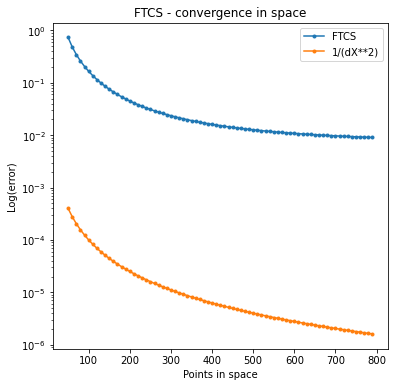

In [24]:
fig, axs = plt.subplots(1,1, figsize = (6,6))
axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.', label='FTCS')
axs.plot(points, 1/points**2, linestyle='-', marker='.', label='1/(dX**2)')
axs.set_xlabel("Points in space")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('FTCS - convergence in space')
plt.legend()
plt.savefig('Figures/convergence_FTCS.pdf', dpi=300)
plt.show()

In [17]:
y_CN = space_experiment("CN", points)

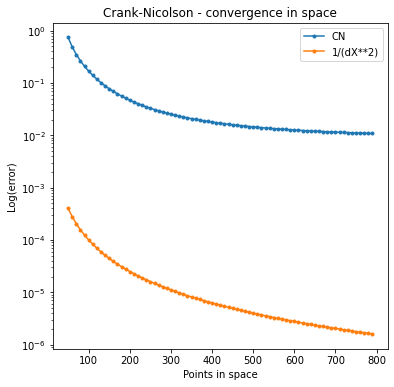

In [25]:
fig, axs = plt.subplots(1,1, figsize = (6,6))
axs.plot(points, abs(y_CN-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.', label='CN')
axs.plot(points, 1/points**2, linestyle='-', marker='.', label='1/(dX**2)')
axs.set_xlabel("Points in space")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('Crank-Nicolson - convergence in space')
plt.legend()
plt.savefig('Figures/convergence_CN.pdf', dpi=300)
plt.show()

In [26]:
points = np.arange(100,4000,600)

In [27]:
# points = np.arange(100,4000,600)
# y = space_experiment("CN", points)

In [28]:
# fig, axs = plt.subplots(1,1, figsize = (6,6))
# axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)),label='CN')
# axs.plot(points, 1/points**2, label='1/(dX**2)')
# axs.set_xlabel("Log(points in space)")
# axs.set_ylabel("Log(error)")
# axs.set_yscale('log')
# axs.set_xscale('log')
# plt.show()

In [29]:
# fig, axs = plt.subplots(1,1, figsize = (6,6))
# axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)), 'ro', label='CN')
# axs.plot(points, 1/points**2, 'bo', label='1/(dX**2)')
# axs.set_xlabel("Log(points in space)")
# axs.set_ylabel("Log(error)")
# axs.set_yscale('log')
# axs.set_xscale('log')
# plt.show()


In [30]:
# y = space_experiment("FCTS", points)

In [31]:
# fig, axs = plt.subplots(1,1, figsize = (6,6))
# axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))
# axs.set_xlabel("Log(points in space)")
# axs.set_ylabel("Log(error)")
# plt.show()

In [33]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))
# ax.set_yscale("log")
# plt.xlabel("Points in Space")
# plt.ylabel("Error")

### Experiment 2: Time points

In [75]:
def time_experiment(scheme, points):
    results = Parallel(n_jobs=10)(delayed(FD_v2)(S, K, r, sigma, T, M, N=int(point), scheme=scheme)
                                 for point in points)
    final = []
    
    for result in results:
        final.append(get_ans(result, S))
        
    return final

In [87]:
points = np.arange(1200,3000,200)
y = time_experiment("FCTS", points)

In [88]:
abs(y-Black_Scholes_Call(S, K, r, sigma, T))

array([[0.00704768],
       [0.0062555 ],
       [0.00566139],
       [0.00519931],
       [0.00482965],
       [0.00452721],
       [0.00427517],
       [0.00406192],
       [0.00387913]])

Text(0, 0.5, 'Error')

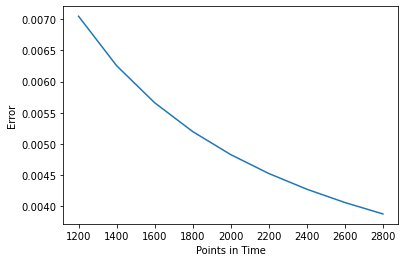

In [89]:
plt.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)))
plt.xlabel("Points in Time")
plt.ylabel("Error")

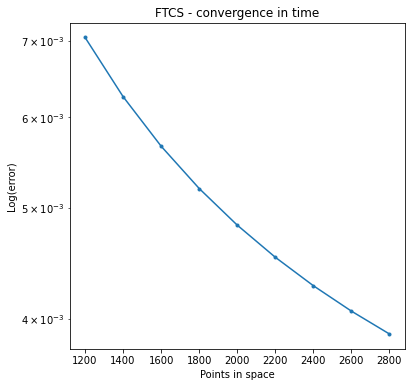

In [97]:
fig, axs = plt.subplots(1,1, figsize = (6,6))
axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.')
# axs.plot(points, 1/points**2, 'bo', label='1/(dX**2)')
axs.set_xlabel("Points in space")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('FTCS - convergence in time')
# plt.legend()
plt.show()

In [174]:
Black_Scholes_Call(S, K, r, sigma, T)

15.128591111967928

In [98]:
points = np.arange(1200,3000,200)
y_CN = time_experiment("CN", points)

Text(0, 0.5, 'Error')

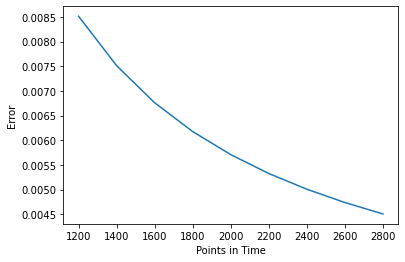

In [99]:
plt.plot(points, abs(y_CN-Black_Scholes_Call(S, K, r, sigma, T)))
plt.xlabel("Points in Time")
plt.ylabel("Error")

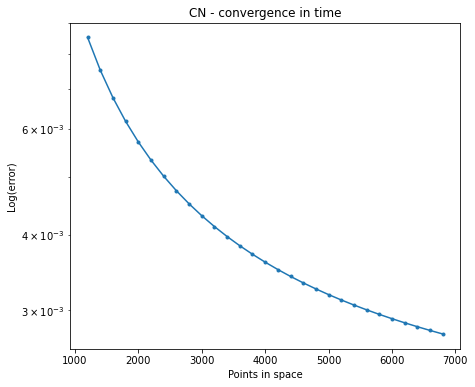

In [114]:
fig, axs = plt.subplots(1,1, figsize = (7,6))
axs.plot(points, abs(y_CN-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.')
# axs.plot(points, 1/points**2, 'bo', label='1/(dX**2)')
axs.set_xlabel("Points in space")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('CN - convergence in time')
# plt.legend()
plt.show()

In [101]:
points = np.arange(1200,7000,200)
y_CN = time_experiment("CN", points)

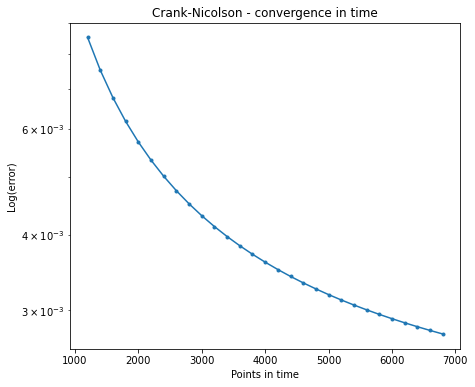

In [117]:
fig, axs = plt.subplots(1,1, figsize = (7,6))
axs.plot(points, abs(y_CN-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.')
# axs.plot(points, 1/points**2, 'bo', label='1/(dX**2)')
axs.set_xlabel("Points in time")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('Crank-Nicolson - convergence in time')
# plt.legend()
plt.savefig('Figures/timeconv_CN_long.pdf', dpi=300)
plt.show()

In [118]:
points = np.arange(1200,7000,200)
y = time_experiment("FCTS", points)

KeyboardInterrupt: 

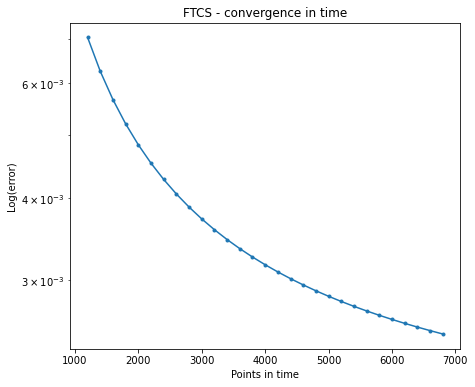

In [119]:
fig, axs = plt.subplots(1,1, figsize = (7,6))
axs.plot(points, abs(y-Black_Scholes_Call(S, K, r, sigma, T)), linestyle='-', marker='.')
# axs.plot(points, 1/points**2, 'bo', label='1/(dX**2)')
axs.set_xlabel("Points in time")
axs.set_ylabel("Log(error)")
axs.set_yscale('log')
# axs.set_xscale('log')
plt.title('FTCS - convergence in time')
# plt.legend()
plt.savefig('Figures/timeconv_FTCS_long.pdf', dpi=300)
plt.show()

### Conlusion: run CN with big mesh

In [120]:
result = FD(S, K, r, sigma, T, 10000, 10000, scheme="CN")
get_ans(result, S)
np.save("data/S_100", result[1])
np.save("data/X_S_100", result[2])

In [121]:
Black_Scholes_Call(S, K, r, sigma, T)

15.128591111967928

## Optimal mesh size FTCS

In [191]:
def FD(S, K, r, sigma, T, N, M, scheme="FCTS"):
    # Compute delta T
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    
    if scheme=="FCTS":
        if not stability(S, K, r, sigma, T, N, M):
            return False
    
    
    s_max = X_true[-1]
    s_min = 0
    
    
    # Generate stock prices on log scale
    # Generate T * S grid
    V = np.zeros((M,N))

    # Put the discounted values into the first column
    V[:, 0] = [max(np.exp(s)-K,0) for s in X]
    V[0, -1] = s_max
    V[0, 0] = s_min
    # Fucking constants
    ss = sigma * sigma
    dxx = dx*dx
    
    # a-1, a0, a+1
    if scheme=="FCTS":
        f = (0.5*ss * dt / dxx)
        g = (r-0.5*ss) *dt / (2*dx)
        h = r * dt
        
        ad = f-g
        a0 = 1-2*f - h
        au = f+g
    else:       
        f = ((r-0.5*ss) * (dt/(4*dx)))
        g = (ss*dt)/(4*dxx)
        h = (r*dt/2)
        
        ad = g-f
        a0 = 1-2*g-h
        au = g+f
        
        
        bd = f-g
        b0 = 1+2*g+h
        bu = -f-g
        
        
    # Generate matrix A
    A = np.zeros((M,M))
    
    np.fill_diagonal(A[1:], ad)
    np.fill_diagonal(A[:,1:], au)
    np.fill_diagonal(A, a0)
    A[0,0], A[0,1], A[-1,-2], A[-1,-1] = 1,0, 0,1
    
    if scheme == "CN":
        B = np.zeros((M,M))
    
        np.fill_diagonal(B[1:], bd)
        np.fill_diagonal(B[:,1:], bu)
        np.fill_diagonal(B, b0)
        
        B[0,0], B[0,1], B[-1,-2], B[-1,-1] = 1,0, 0,1

        
    # main loop
    if scheme == "CN":
        for i in range(1,N):
            b = np.matmul(A, V[:, i-1])
            n = len(b)
            w= np.zeros(n-1, float)
            g= np.zeros(n, float)
            p = np.zeros(n,float)
            V[:, i]  = TDMA(B.diagonal(-1),B.diagonal(0), B.diagonal(+1), b, w, g, p, n)
    else:
        for i in range(1,N):
            V[:, i] = np.matmul(A, V[:, i-1])

    return A, V , X

# returns the answer from a result object
def get_ans(result, S):
    if result == False:
        return None
    nearest_idx = np.where(abs(np.exp(result[2])-S)==abs(np.exp(result[2])-S).min())[0]
    return result[1][nearest_idx, -1]


def stability(S, K, r, sigma, T, N, M):
    dt = T/N
    M_h = int(M/2)
    M -= 1
    S_log = np.log(S)
    
    Xp1 = np.logspace(0,S_log,M_h,endpoint=True, base=math.e)
    Xp2 = np.logspace(S_log,S_log*2,M_h,endpoint=True, base=math.e)
    X_true = [*Xp1, *Xp2[1:]]
    X = np.log(X_true)
        
    dx = (X[-1] - X[0])/(M-1);
    mesh_ratio = (dt*(2*sigma**2 + dx**2)) / (4*dx**2)
    if mesh_ratio <= 0.5:
        if mesh_ratio >= 0:
            return True
    return False


#https://stackoverflow.com/questions/8733015/tridiagonal-matrix-algorithm-tdma-aka-thomas-algorithm-using-python-with-nump
@jit(nopython=False)
def TDMA(a,b,c,d, w, g, p, n):
    #n = len(d)
    #w= np.zeros(n-1,float)
    #g= np.zeros(n, float)
    #p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [322]:
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [354]:
# basic parameters
sigma = 0.3
K = 110
S = 110
r = 0.04
T = 1
N = 500 # time points
M =  800# space points

In [355]:
BS_val = Black_Scholes_Call(S, K, r, sigma, T)
BS_val

15.128591111967928

In [356]:
def timespace_experiment(scheme, M_points, N_points):
    final = []
    final_time = []
    final_space = []
    for Np in N_points:
        results = Parallel(n_jobs=10)(delayed(FD)(S, K, r, sigma, T, Np, M=int(point), scheme=scheme)
                                     for point in M_points)
    
        for result in results:
            final_time.append(Np)
            final_space.append(M_points)
            final.append(get_ans(result, S))
        
    return final, final_time, final_space

In [357]:
result = FD(S, K, r, sigma, T, N, M, scheme="FCTS")
x = get_ans(result, S)
print(x)

None


In [358]:
M_points = np.arange(100,3001,100)
N_points = np.arange(3000,99,-100)
y, time, space = timespace_experiment("FCTS", M_points, N_points)

In [359]:
space[i]

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000])

In [360]:
list_space = []
for i in range(len(N_points)):
    x = list(space[i])
    list_space = [*list_space, *x]

In [361]:
errors = []
time_points = []
space_points = []
for i in range(len(y)):
    if y[i] is None:
        continue
    else:
        err = abs(y[i][0] - BS_val)
        errors.append(err)
        time_points.append(time[i])
        space_points.append(list_space[i])

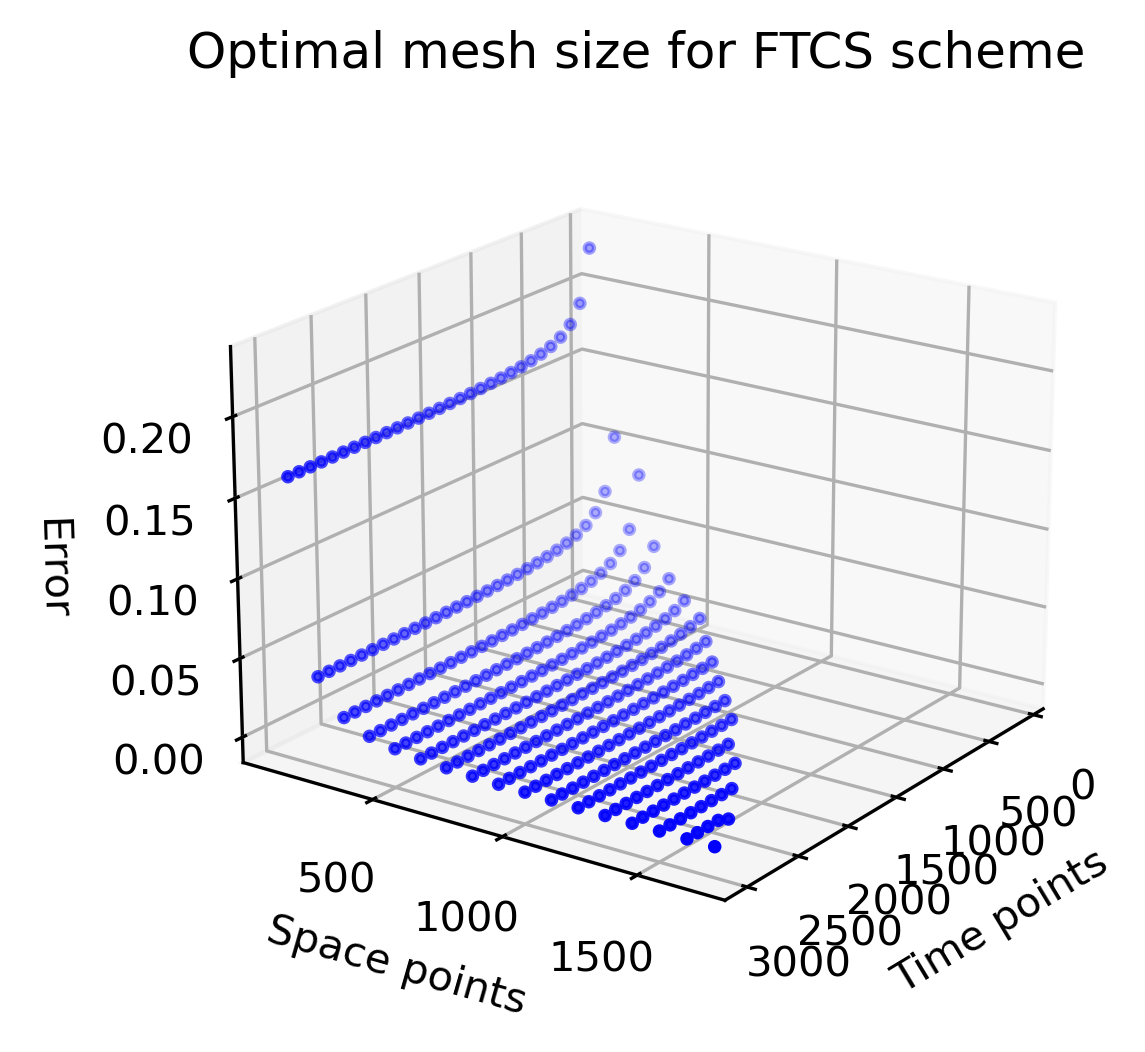

In [364]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=300)

# Data for a three-dimensional line
zdata = errors
xdata = time_points
ydata = space_points
ax.scatter3D(xdata, ydata, zdata, color='blue', marker='.')
ax.view_init(20, 35)
ax.set_xlabel('Time points')
ax.set_ylabel('Space points')
ax.set_zlabel('Error')
plt.title('Optimal mesh size for FTCS scheme')
plt.savefig('Figures/meshsize_FTCS.pdf', dpi=300)
plt.show()

### Retrieve hedge parameter from data

### Retrieve hedge parameter from data

In [165]:
# basic parameters
sigma = 0.3
K = 110
S = 110
r = 0.04
T = 1
N = 1200 # time points
M =  1000# space points

In [166]:
def Delta_Analytical_Call(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

In [167]:
Delta_Analytical_Call(100, K, r, sigma, 1)

0.48629214299030143

In [168]:
def get_delta(result, S, timepoint = -1):
    nearest_idx = np.where(abs(np.exp(result[2])-S)==abs(np.exp(result[2])-S).min())[0]
    delV = result[1][nearest_idx+1, timepoint] - result[1][nearest_idx-1, timepoint]
    stonks = np.exp(result[2])
    delS = stonks[nearest_idx+1] - stonks[nearest_idx-1]
    return delV/delS

In [169]:
get_delta(result, 100)

array([0.48768335])

In [170]:
get_delta(result, 100, 30)

array([0.02672678])

In [171]:
np.arange(80, 150, 3)

array([ 80,  83,  86,  89,  92,  95,  98, 101, 104, 107, 110, 113, 116,
       119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149])

In [172]:
deltas = []
ss = np.arange(20, 250, 3)
tt = [0,3000,-1]
for t in tt:
    time = []
    for s in ss:
        time.append(get_delta(result, s, t))
    deltas.append(time)

IndexError: index 3000 is out of bounds for axis 1 with size 1200

Text(0, 0.5, 'Delta')

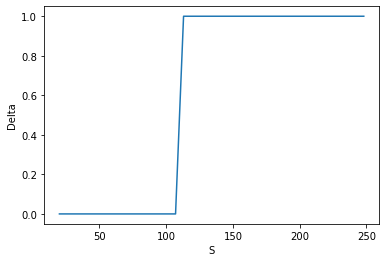

In [173]:
plt.plot(ss, deltas[0])
plt.xlabel("S")
plt.ylabel("Delta")

In [174]:
plt.plot(ss, deltas[1])
plt.xlabel("S")
plt.ylabel("Delta")

IndexError: list index out of range

In [175]:
plt.plot(ss, deltas[2])
plt.xlabel("S")
plt.ylabel("Delta")

IndexError: list index out of range